In [1]:
#%pip install yfinance
#%pip install pmdarima
#!pip install tslearn

In [2]:
# For data manipulation
import os
from dotenv import load_dotenv
from tvDatafeed import TvDatafeedLive, Interval
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
from dtaidistance import dtw
from scipy.signal import correlate
import pmdarima as pm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict

# Load environment variables from .env file
load_dotenv()

# Retrieve TradingView credentials from environment variables
username = os.environ.get("TRADINGVIEW_USERNAME")
password = os.environ.get("TRADINGVIEW_PASSWORD")

# Initialize TradingView live data feed
tv = TvDatafeedLive(username, password)

# Fetch historical data for XAUUSD (2000 hourly bars)
forex_data_hour = tv.get_hist(symbol='XAUUSD', exchange='ICMARKETS',
                              interval=Interval.in_15_minute, n_bars=4000)

prices = forex_data_hour['close']
prices

error while signin
you are using nologin method, data you access may be limited


datetime
2024-09-05 11:00:00    2508.16
2024-09-05 11:15:00    2514.01
2024-09-05 11:30:00    2515.17
2024-09-05 11:45:00    2514.73
2024-09-05 12:00:00    2516.64
                        ...   
2024-11-05 21:45:00    2740.57
2024-11-05 22:00:00    2741.64
2024-11-05 22:15:00    2741.60
2024-11-05 22:30:00    2740.97
2024-11-05 22:45:00    2743.30
Name: close, Length: 4000, dtype: float64

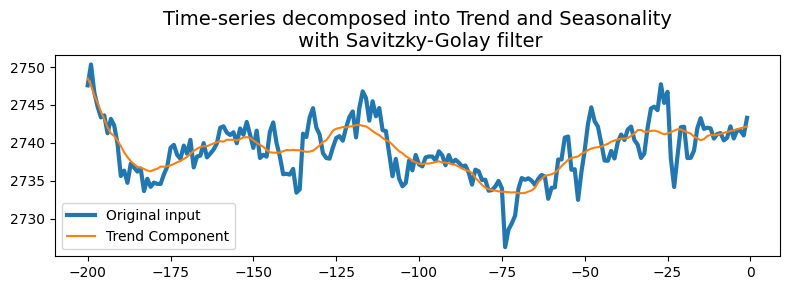

In [3]:
# Save the original time index
original_time_index = prices.index

# Reset the index to 0 to 999
prices = prices.reset_index(drop=True)

yvalues = prices
yvalues_trend = savgol_filter(yvalues,19,1)
yvalues_seasonal = yvalues-yvalues_trend

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(np.arange(-200,0), yvalues[-200:], label='Original input',linewidth=3)
ax.plot(np.arange(-200,0), yvalues_trend[-200:], label='Trend Component')
#ax.plot(yvalues_seasonal, label='Seasonal Component')
ax.legend()
ax.set_title('Time-series decomposed into Trend and Seasonality\n with Savitzky-Golay filter', fontsize=14)
plt.tight_layout()
plt.show()


In [4]:
# Definition of Forecast Parameters
forecast_elements = 24

# Trend - fit stepwise auto-ARIMA
smodel = pm.auto_arima(yvalues_trend, start_p=1, start_q=1,
                         test='adf',
                         max_p=4, max_q=4,
                         start_P=0, seasonal=False,
                         d=None, D=0, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
smodel.summary()

forecast = smodel.predict(n_periods=forecast_elements)

# Extend trend forecast
yvalues_trend_forecast = np.concatenate((yvalues_trend, forecast))

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3431.929, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5007.438, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3428.248, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1271.321, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5068.934, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3459.053, Time=0.58 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3432.344, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3432.875, Time=1.72 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3432.834, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3434.897, Time=0.41 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-3434.871, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-3430.870, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-3457.404, Time=0.56 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 5.704 seconds


In [5]:
def fft_forecast(signal, forecast_elements, target_harmonics=40):

    # Perform FFT on the seasonal component
    N = len(signal)
    fft_result = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(N)

    # **2. Retain non-negative frequencies (including zero)**
    positive_freq_indices = fft_freq >= 0
    fft_freq_positive = fft_freq[positive_freq_indices]
    fft_result_positive = fft_result[positive_freq_indices]

    # Limit the number of harmonics
    num_harmonics = min(target_harmonics, len(fft_freq_positive))
    frequencies = fft_freq_positive[:num_harmonics]
    amplitudes = fft_result_positive[:num_harmonics]

    # **3. Create extended indices including future points**
    reconstructed_length = N + forecast_elements
    extended_indices = np.arange(reconstructed_length)

    # **4. Reconstruct the signal using the selected harmonics**
    reconstructed_signal = np.zeros(reconstructed_length)

    for i in range(num_harmonics):
        frequency = frequencies[i]
        amplitude_complex = amplitudes[i]
        amplitude = np.abs(amplitude_complex)
        phase = np.angle(amplitude_complex)
        omega = 2 * np.pi * frequency

        if frequency == 0:  # DC component
            reconstructed_signal += (amplitude / N) * np.ones_like(extended_indices)
        else:
            reconstructed_signal += (2 * amplitude / N) * np.cos(omega * extended_indices + phase)
    
    return reconstructed_signal, num_harmonics

In [6]:
# Definition of Forecast Parameters
validation_elements = 8
seasonal_harmonics_list = np.arange(40, 80, 5)
seasonal_input_elements_list = np.arange(200, 800, 5)
visualization_elements = 120

# Initialize a list to store results
results = []

# Define error metric: Root Mean Squared Error (RMSE)
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# Generate forecasts by looping over different parameters
for seasonal_harmonics in seasonal_harmonics_list:
    for seasonal_input_elements in seasonal_input_elements_list:
        # Calculate starting index, and get input data slice
        start_idx = len(yvalues_seasonal) - validation_elements - seasonal_input_elements
        input_slice = yvalues_seasonal[start_idx:start_idx+seasonal_input_elements]

        # Generate forecast with FFT
        yvalues_seasonal_forecast, num_harmonics = fft_forecast(
            input_slice,
            validation_elements+forecast_elements,
            seasonal_harmonics
        )
        
        # Convert forecasts to numpy arrays if they're pandas Series
        if isinstance(yvalues_seasonal_forecast, pd.Series):
            yvalues_seasonal_forecast = yvalues_seasonal_forecast.to_numpy()
        if isinstance(yvalues_seasonal, pd.Series):
            yvalues_seasonal = yvalues_seasonal.to_numpy()

        # Extract validation and test portions
        actual_validation = yvalues_seasonal[-validation_elements:]
        forecast_validation = yvalues_seasonal_forecast[-validation_elements-forecast_elements:-forecast_elements]

        # Calculate distances
        validation_distance = dtw.distance(actual_validation, forecast_validation)

        # Calculate cross-correlation for validation set
        validation_cross_corr = correlate(actual_validation, 
                                            forecast_validation, 
                                            mode='full')
        validation_max_corr = max(validation_cross_corr)

        # Store the results
        results.append({
            'seasonal_input_length': seasonal_input_elements,
            'seasonal_harmonics': seasonal_harmonics,
            'rmse_validation': calculate_rmse(actual_validation, forecast_validation),
            'dtw_validation': validation_distance,
            'cc_validation': validation_max_corr,
        })

results_df = pd.DataFrame(results)
results_df.sort_values(by='dtw_validation', ascending=True).head(20)

,seasonal_input_length,seasonal_harmonics,rmse_validation,dtw_validation,cc_validation
888,440,75,0.981565,1.625669,1.997443
939,695,75,0.813834,1.674629,3.030402
339,695,50,0.929428,1.677988,3.332596
300,500,50,1.155687,1.696819,2.156442
146,330,45,0.882208,1.700339,2.923110
955,775,75,1.226953,1.708306,1.758559
288,440,50,0.846671,1.727939,2.492139
713,765,65,1.018900,1.762207,3.442261
26,330,40,0.949136,1.785113,2.971521
172,460,45,1.362622,1.787255,1.178664


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict

def find_optimal_clusters(data, max_clusters=4):
    """Find optimal number of clusters using silhouette score."""
    # data is expected to be a 2D array of shape (n_samples, n_timepoints)
    n_samples = data.shape[0]
    data_reshaped = data.reshape(n_samples, -1)  # Ensure data is 2D
    
    # Try different numbers of clusters
    silhouette_scores = []
    for k in range(2, min(max_clusters + 1, n_samples)):
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(data_reshaped)
        score = silhouette_score(data_reshaped, cluster_labels)
        silhouette_scores.append(score)
    
    # Return optimal number of clusters
    optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
    return optimal_k

def plot_forecast_with_clusters(param_df, alpha_value=0.5, max_clusters=10):
    # Prepare common data slices and indices
    len_original_slice = visualization_elements + validation_elements
    len_forecast_slice = visualization_elements + validation_elements + forecast_elements
    original_slice_idx_list = np.arange(-len_original_slice, 0)
    forecast_slice_idx_list = np.arange(-len_original_slice, forecast_elements)
    
    # Prepare the prices slice and trend slice
    prices_slice = prices[-visualization_elements - validation_elements:]
    yvalues_trend_slice = yvalues_trend_forecast[-len_forecast_slice:]
    
    # Get the last data time
    last_datetime = forex_data_hour.index[-1]
    
    # Initialize lists to store forecasts
    seasonal_forecast_slices = []
    combined_forecast_slices = []
    
    # For each parameter set in param_df
    for idx, row in param_df.iterrows():
        seasonal_input_elements = int(row['seasonal_input_length'])
        seasonal_harmonics = int(row['seasonal_harmonics'])
        
        start_idx = len(yvalues_seasonal) - validation_elements - seasonal_input_elements
        input_slice = yvalues_seasonal[start_idx:start_idx + seasonal_input_elements]
        
        yvalues_seasonal_forecast, num_harmonics = fft_forecast(
            input_slice,
            validation_elements + forecast_elements,
            seasonal_harmonics
        )
        
        seasonal_forecast_slice = yvalues_seasonal_forecast[-len_forecast_slice:]
        combined_forecast_slice = yvalues_trend_slice + seasonal_forecast_slice
        
        seasonal_forecast_slices.append(seasonal_forecast_slice)
        combined_forecast_slices.append(combined_forecast_slice)
    
    # Convert to numpy arrays for easier manipulation
    seasonal_forecast_slices = np.array(seasonal_forecast_slices)
    combined_forecast_slices = np.array(combined_forecast_slices)

    # Get the validation and first half of forecast data for clustering
    end_idx = -forecast_elements//2
    start_idx = -(validation_elements + forecast_elements)
    clustering_data = seasonal_forecast_slices[:, start_idx:end_idx]
    n_samples = clustering_data.shape[0]
    data_reshaped = clustering_data.reshape(n_samples, -1)
    
    # Find optimal number of clusters
    n_clusters = find_optimal_clusters(clustering_data, 3)

    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data_reshaped)
    
    # Group forecasts by cluster
    cluster_members = defaultdict(list)
    for idx, label in enumerate(cluster_labels):
        cluster_members[label].append(idx)
    
    # Calculate cluster means and intra-cluster distances
    cluster_means = {}
    intra_cluster_distances = {}
    for label, indices in cluster_members.items():
        cluster_data = combined_forecast_slices[indices]
        cluster_means[label] = np.mean(cluster_data, axis=0)
        
        # Compute intra-cluster distance (mean pairwise distance within the cluster)
        distances = []
        for i in range(len(indices)):
            for j in range(i+1, len(indices)):
                dist = np.linalg.norm(cluster_data[i] - cluster_data[j])
                distances.append(dist)
        if distances:
            intra_cluster_distance = np.mean(distances)
        else:
            intra_cluster_distance = 0  # Single member in cluster
        intra_cluster_distances[label] = intra_cluster_distance
    
    # Plotting
    plt.figure(figsize=(12, 12))
    
    # Plot original price and trend
    plt.subplot(3, 1, 1)
    plt.plot(original_slice_idx_list / 4, prices_slice, label="Original Price")
    plt.plot(forecast_slice_idx_list / 4, yvalues_trend_slice, label='Trend Component', color='pink')
    
    # Plot combined forecasts with clusters
#    colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))
    colors = ['green', 'red', 'magenta', 'cyan']
    for label, indices in cluster_members.items():
        # Plot individual forecasts with transparency
#        for idx in indices:
#            plt.plot(
#                forecast_slice_idx_list / 4,
#                combined_forecast_slices[idx],
#                color=colors[idx],
#                alpha=alpha_value
#            )
        # Plot cluster mean
        plt.plot(
            forecast_slice_idx_list / 4,
            cluster_means[label],
            color=colors[label],
            linewidth=2,
            label=f'Cluster {label} (n={len(indices)}, intra-dist={intra_cluster_distances[label]:.2f})'
        )
    
    plt.axvline(x=0, color='red', linestyle='--')
    plt.axvline(x=-validation_elements / 4, color='orange', linestyle='--')
    plt.axvline(x=validation_elements / 4, color='violet', linestyle='--')
    plt.title(f"Original Prices with Clustered Forecasts - {last_datetime}")
    plt.xlabel("Hours")
    plt.ylabel("Prices")
    plt.grid(True)
    plt.legend(loc = "lower left")
    
    # Plot original and reconstructed seasonal components
    plt.subplot(3, 1, 2)
    seasonal_original_slice = yvalues_seasonal[-visualization_elements - validation_elements:]
    plt.plot(original_slice_idx_list / 4, seasonal_original_slice, label="Original Seasonal", color='blue')
    
    # Plot seasonal forecasts with clusters
    seasonal_cluster_means = {}
    for label, indices in cluster_members.items():
        # Calculate seasonal cluster means
        seasonal_cluster_data = seasonal_forecast_slices[indices]
        seasonal_cluster_means[label] = np.mean(seasonal_cluster_data, axis=0)
        
        # Plot individual seasonal forecasts
        for idx in indices:
            plt.plot(
                forecast_slice_idx_list / 4,
                seasonal_forecast_slices[idx],
                color='pink',
                alpha=alpha_value
            )
        # Plot seasonal cluster mean
#        plt.plot(
#            forecast_slice_idx_list / 4,
#            seasonal_cluster_means[label],
#            color=colors[label],
#            linewidth=2,
#            label=f'Cluster {label} (n={len(indices)}, intra-dist={intra_cluster_distances[label]:.2f})'
#        )
    
    plt.axvline(x=-validation_elements / 4, color='orange', linestyle='--', label="Validation Start")
    plt.axvline(x=0, color='red', linestyle='--', label="Forecast Start")
    plt.axvline(x=validation_elements / 4, color='violet', linestyle='--', label="70% Boundary")
    plt.title("Original Seasonal vs Clustered Seasonal Forecasts")
    plt.xlabel("Hours")
    plt.ylabel("Prices")
    plt.grid(True)
    plt.legend(loc = "lower left")
    
    plt.tight_layout()
    plt.show()
    
    return cluster_labels, cluster_members


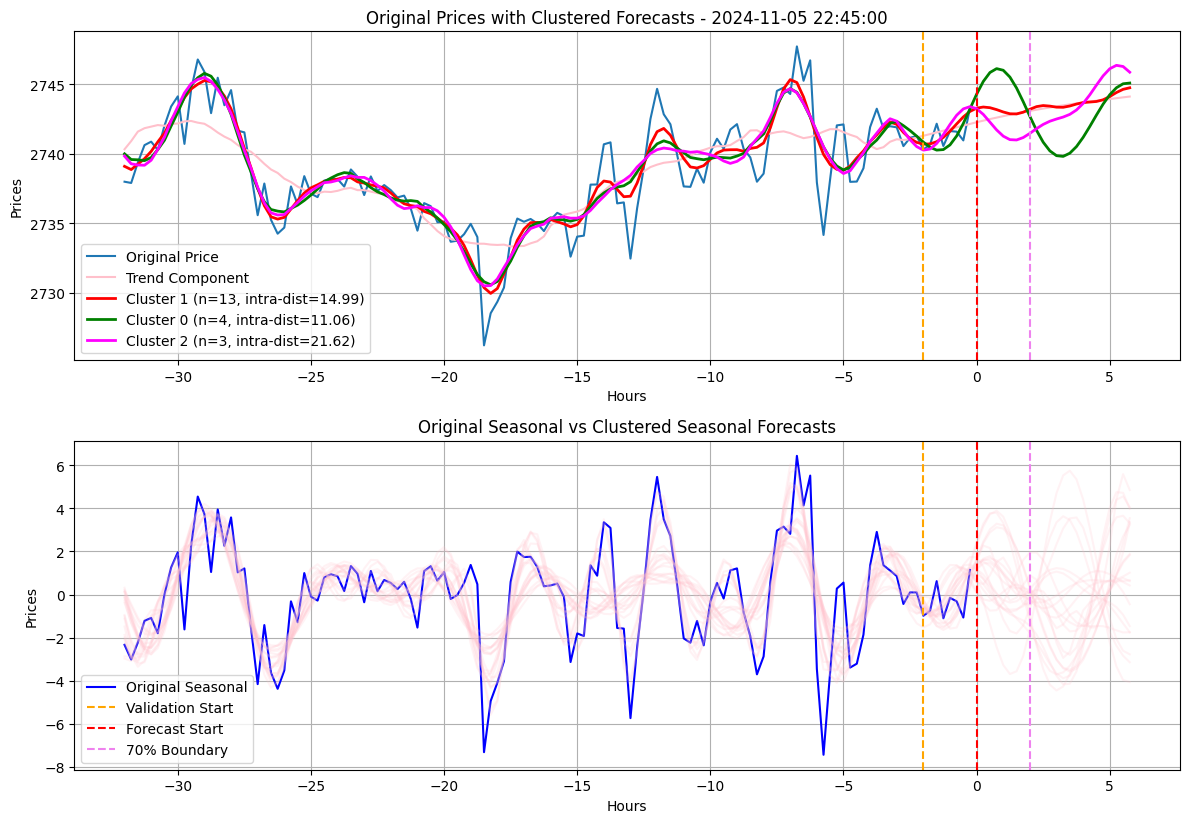

(array([1, 0, 0, 2, 1, 1, 1, 0, 1, 1, 2, 1, 0, 1, 1, 2, 1, 1, 1, 1],
       dtype=int32),
 defaultdict(list,
             {1: [0, 4, 5, 6, 8, 9, 11, 13, 14, 16, 17, 18, 19],
              0: [1, 2, 7, 12],
              2: [3, 10, 15]}))

In [8]:
# Sort the dataframe first
sorted_df = results_df.sort_values(by='dtw_validation', ascending=True).reset_index(drop=True)

plot_forecast_with_clusters(sorted_df[:20], 0.2)